# DATA ANALYSIS - DESCRIPTIVE STATISTICS

`Author: José Luis Maldonado Álvarez`

## 1. Univariate Analysis

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(dplyr))

df <- read.csv('CURATED_DATASET.csv')
cols_to_exclude <- c('ID', 'OUT_Ddate', 'OUT_AMIdate', 'OUT_STKdate', 'OUT_HEMdate', 'OUT_REVdate', 'OUT_MACEdate')
df[] <- lapply(names(df), function(col) {
    if (col %in% cols_to_exclude) df[[col]] else as.factor(df[[col]])
})

# Function to plot the distribution of the variables of a DataFrame
plot_variable_distributions <- function(df, exclude_columns = character(0), start_with = character(0)) {
    columns_to_plot <- names(df)[
        !(names(df) %in% exclude_columns) &
            sapply(names(df), function(col) any(startsWith(col, start_with)))
    ]
    num_columns <- length(columns_to_plot)
    num_rows <- ceiling(num_columns / 4)
    plots <- list()
    for (column in columns_to_plot) {
        vc_percent <- df %>% # Calculate the percentage of each value
            count(!!sym(column)) %>% # Count occurrences of each value
            mutate(percent = n / sum(n) * 100) # Calculate percentage
        p <- ggplot(vc_percent, aes(x = !!sym(column), y = percent)) +
            geom_bar(stat = "identity", fill = "#53868B") +
            geom_text(aes(label = sprintf("%.2f%%", percent)), vjust = -0.5) +
            ylim(0, 100) +
            ggtitle(column) +
            theme_minimal() +
            theme(
                plot.title = element_text(face = "bold", hjust = 0.5), # título centrado
                panel.border = element_rect(colour = "black", fill = NA, size = 1), # recuadro
                # panel.grid.major = element_blank(), # Remove major grid lines
                # panel.grid.minor = element_blank()  # Remove minor grid lines
            )
        plots[[column]] <- p
    }
    if (num_rows * 4 > num_columns) {
        for (i in (num_columns + 1):(num_rows * 4)) {
            plots[[i]] <- ggplot() + theme_void()
        }
    }
    options(repr.plot.width = 16, repr.plot.height = 5 * num_rows) # Set the plot size
    grid.arrange(grobs = plots, nrow = num_rows, ncol = 4) # Arrange plots in a grid
}

Warning message:
"package 'ggplot2' was built under R version 4.4.3"


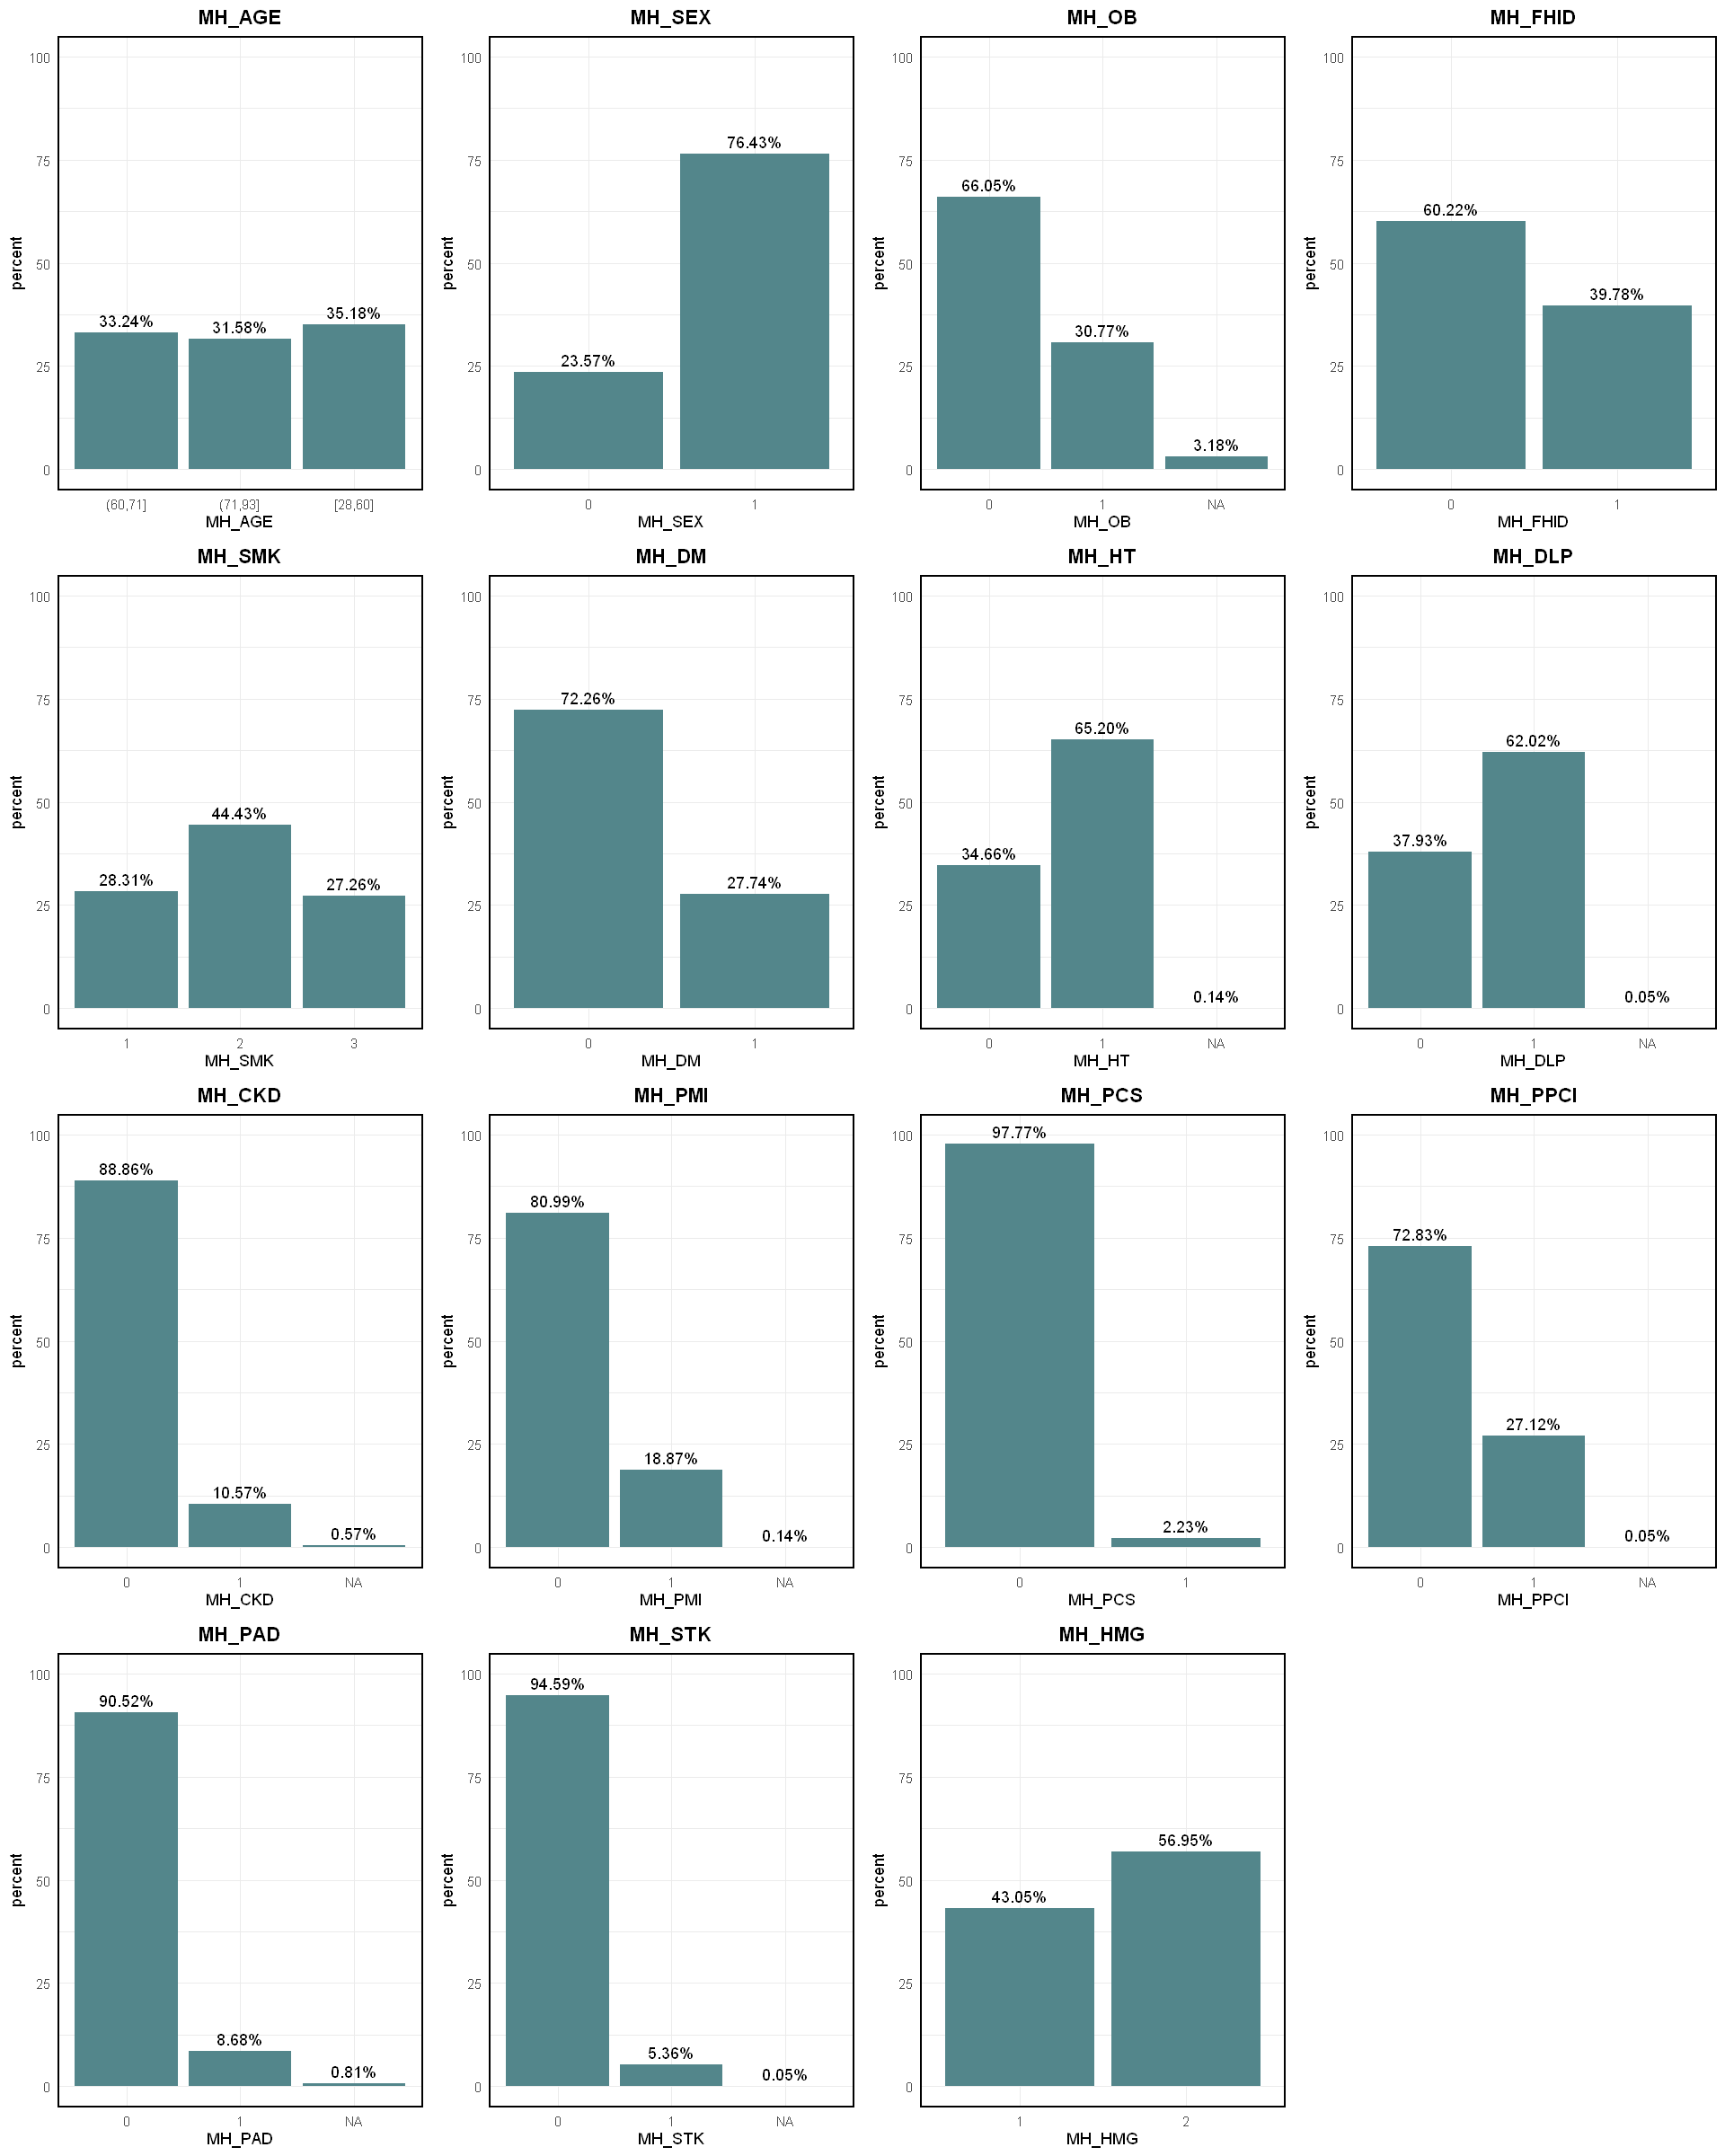

In [2]:
# Plot the distribution of the medical history variables
suppressWarnings(plot_variable_distributions(df, start_with = c('MH')))

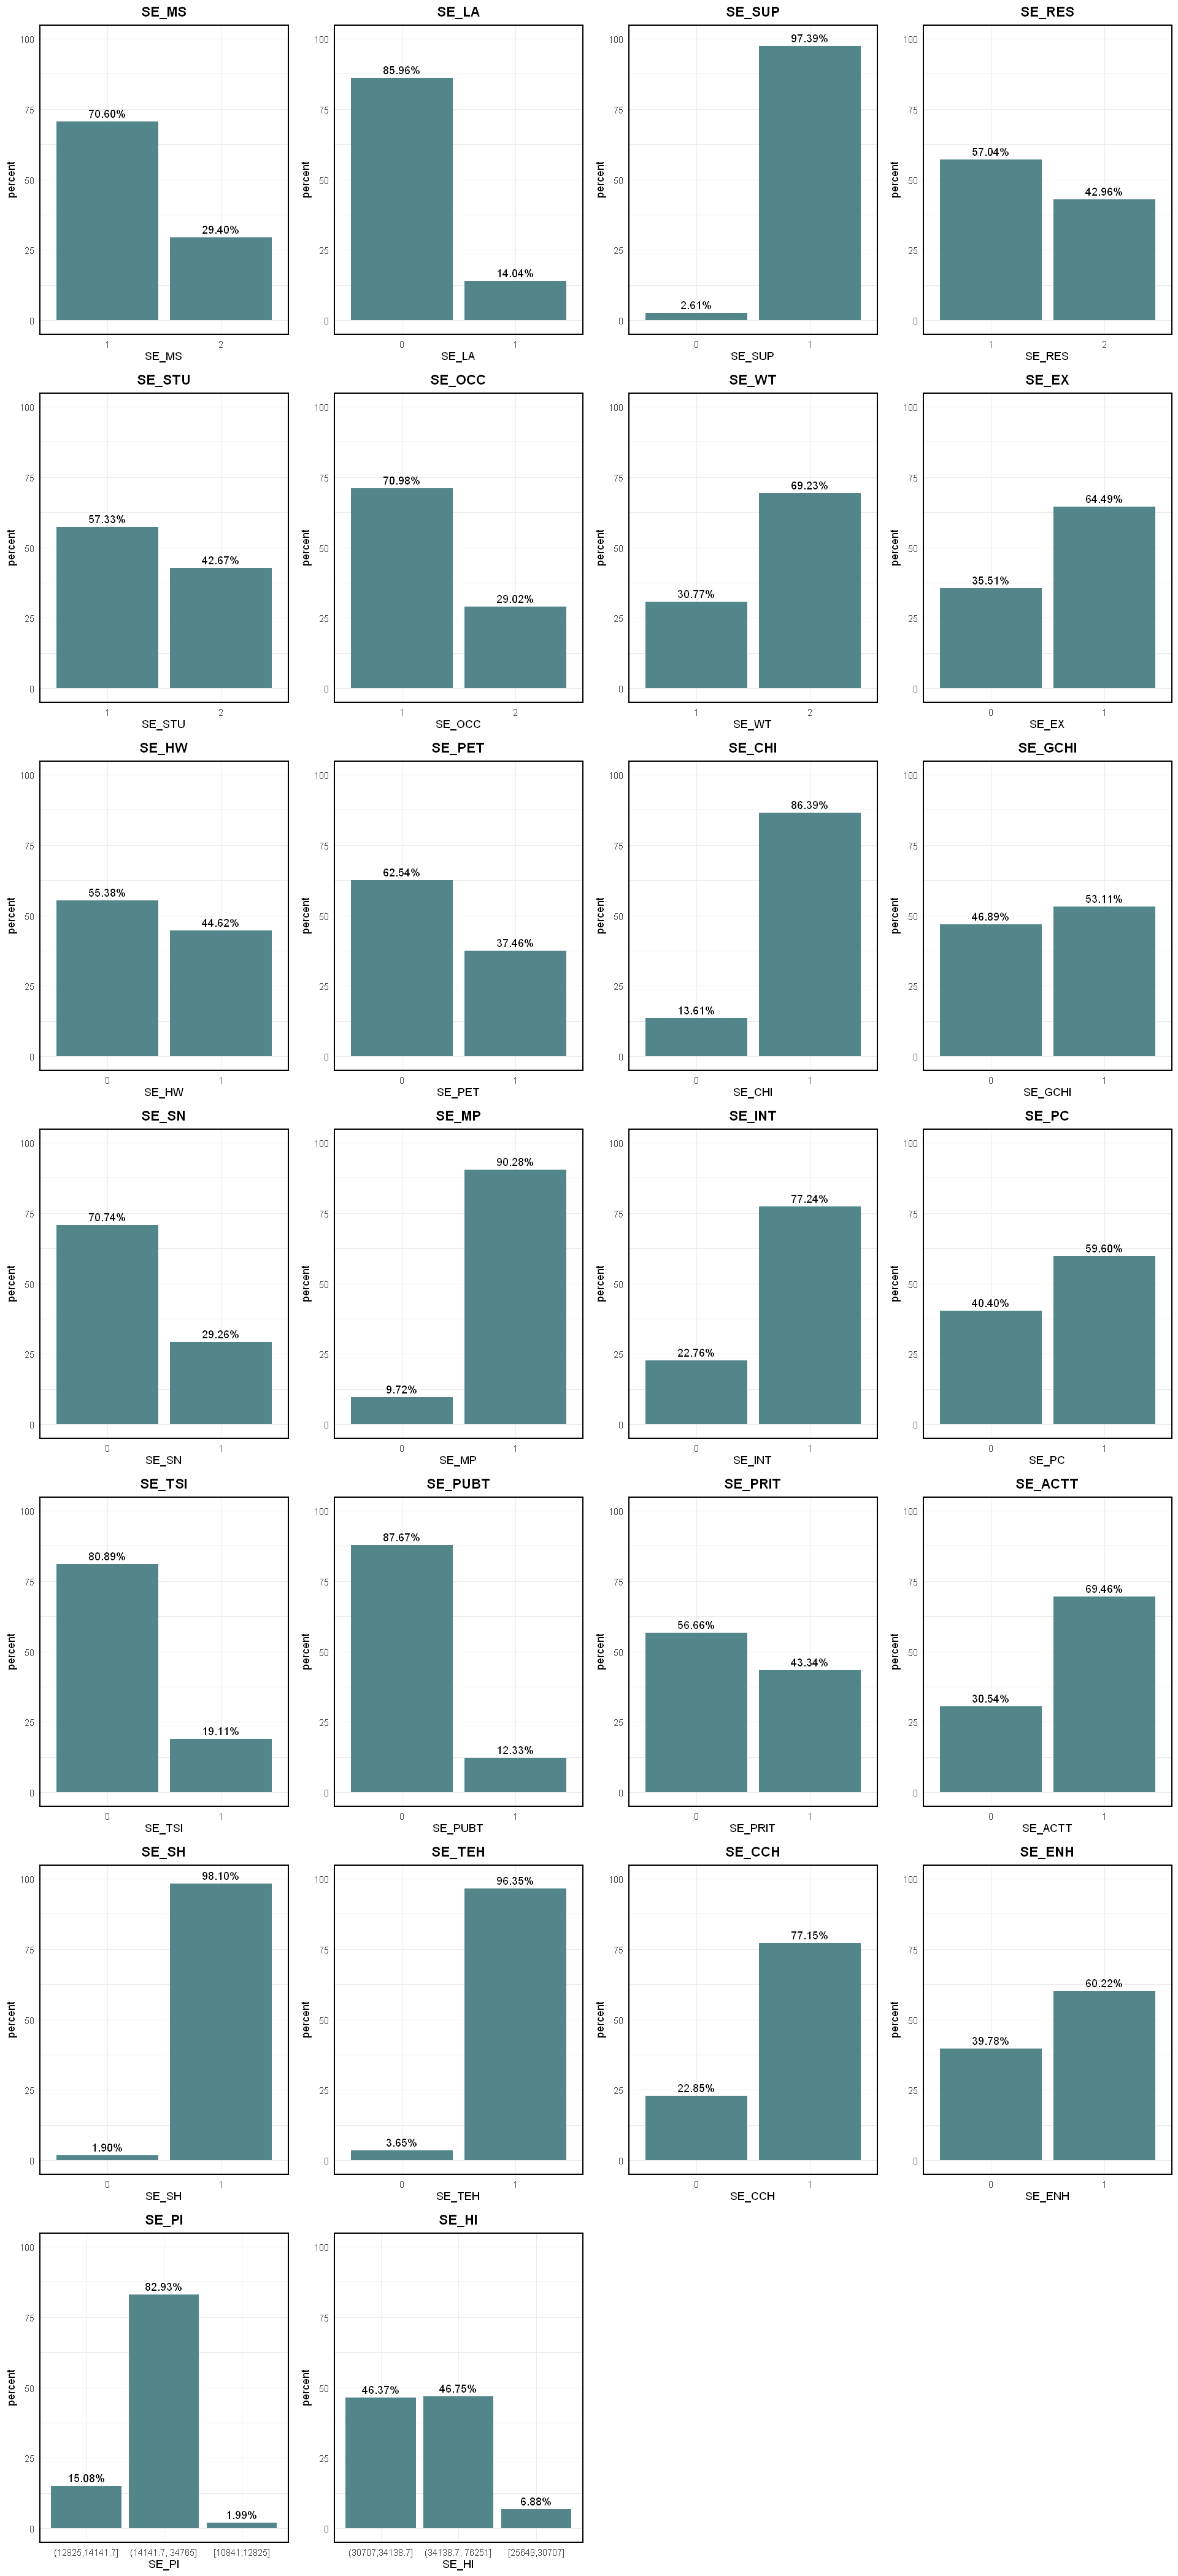

In [3]:
# Plot the distribution of the socioeconomic variables
suppressWarnings(plot_variable_distributions(df, start_with = c('SE')))

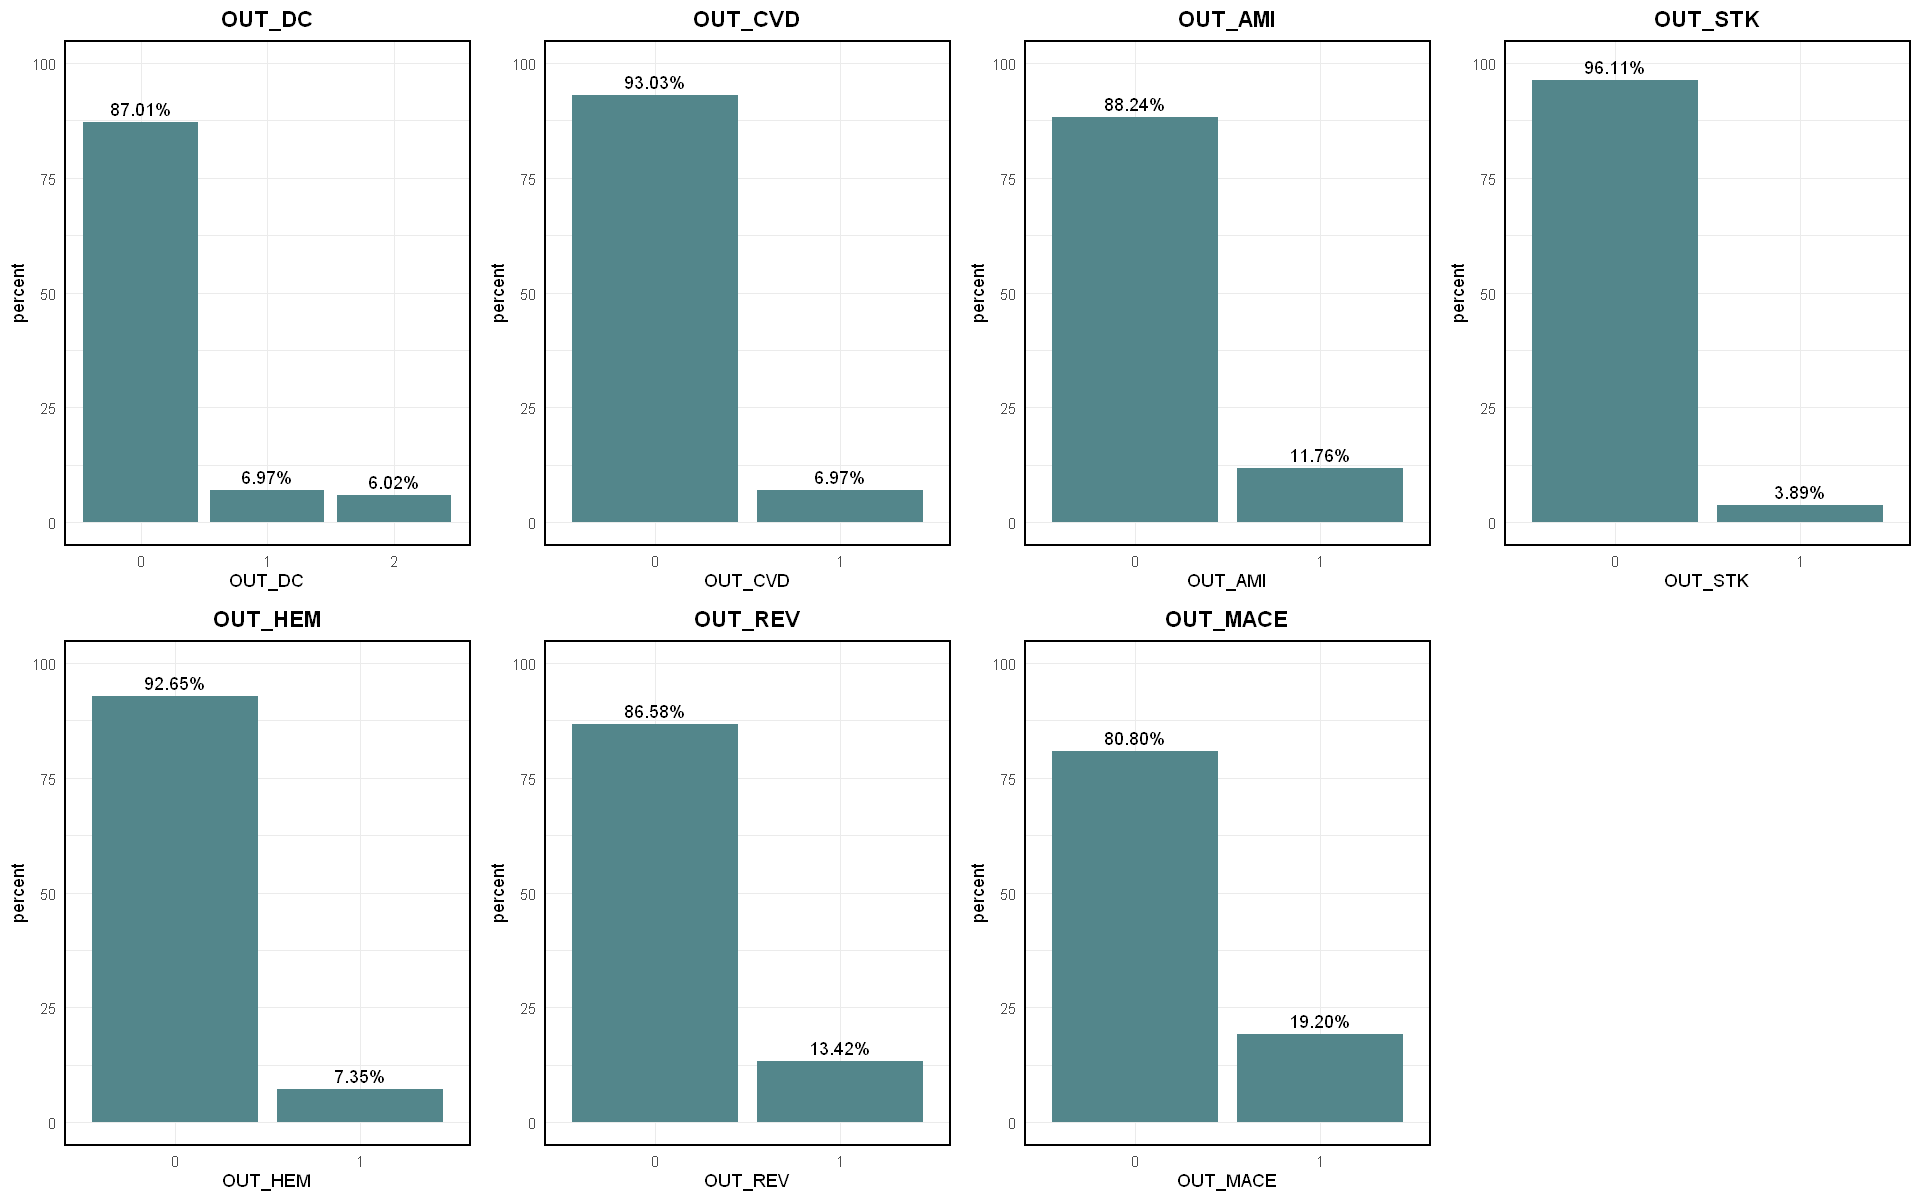

In [4]:
# Plot the distribution of the outcome variables, excluding specific columns
suppressWarnings(plot_variable_distributions(
    df,
    exclude_columns = c('OUT_Ddate', 'OUT_AMIdate', 'OUT_STKdate', 'OUT_HEMdate', 'OUT_REVdate', 'OUT_MACEdate'),
    start_with = c('OUT')
))

## 2. Bivariate Analysis

### 2.1. Cramer's V Matrix

In [5]:
# Function to calculate Cramer's V correlation coefficient between 
# every two categorical variables
cramers_v <- function(x, y) {
    tbl <- table(x, y)
    chi2 <- suppressWarnings(chisq.test(tbl, correct = FALSE)$statistic)
    n <- sum(tbl)
    phi2 <- chi2 / n
    r <- nrow(tbl)
    k <- ncol(tbl)
    phi2corr <- max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr <- r - ((r - 1)^2) / (n - 1)
    kcorr <- k - ((k - 1)^2) / (n - 1)
    sqrt(phi2corr / min(kcorr - 1, rcorr - 1))
}

# Function to calculate Cramer's V matrix for selected variables
calculate_cramer_v <- function(df) {
    variables <- setdiff(names(df), c('ID', 'OUT_Ddate', 'OUT_AMIdate', 'OUT_STKdate', 'OUT_HEMdate', 'OUT_REVdate', 'OUT_MACEdate'))
    n <- length(variables)
    result_matrix <- matrix(0, nrow = n, ncol = n)
    for (i in seq_len(n)) {
        for (j in seq_len(n)) {
            if (i == j) {
                result_matrix[i, j] <- 1.0
            } else {
                result_matrix[i, j] <- cramers_v(df[[variables[i]]], df[[variables[j]]])
            }
        }
    }
    colnames(result_matrix) <- variables
    rownames(result_matrix) <- variables
    as.data.frame(result_matrix)
}

Warning message:
"package 'reshape2' was built under R version 4.4.2"




| Variable 1 | Variable 2 | Cramer's V |
|:----------:|:----------:|:----------:|
|   MH_SMK   |   MH_AGE   |   0.305    |
|   SE_OCC   |   MH_AGE   |   0.634    |
|  SE_GCHI   |   MH_AGE   |   0.552    |
|   SE_SN    |   MH_AGE   |   0.393    |
|   SE_INT   |   MH_AGE   |   0.445    |
|   SE_PC    |   MH_AGE   |   0.373    |
|   MH_SMK   |   MH_SEX   |   0.305    |
|   MH_HMG   |   MH_SEX   |   0.482    |
|  MH_PPCI   |   MH_PMI   |   0.636    |
|   SE_LA    |   SE_MS    |   0.599    |
|   SE_CHI   |   SE_MS    |   0.317    |
|   SE_SUP   |   SE_LA    |   0.336    |
|  SE_PUBT   |   SE_RES   |   0.338    |
|   SE_PI    |   SE_RES   |   0.314    |
|   SE_WT    |   SE_STU   |   0.513    |
|   SE_PC    |   SE_STU   |   0.337    |
|  SE_GCHI   |   SE_OCC   |   0.416    |
|  SE_GCHI   |   SE_CHI   |   0.422    |
|   SE_INT   |   SE_SN    |   0.343    |
|   SE_PC    |   SE_SN    |   0.325    |
|   SE_INT   |   SE_MP    |   0.310    |
|   SE_PC    |   SE_INT   |   0.641    |
|  SE_ACTT   |

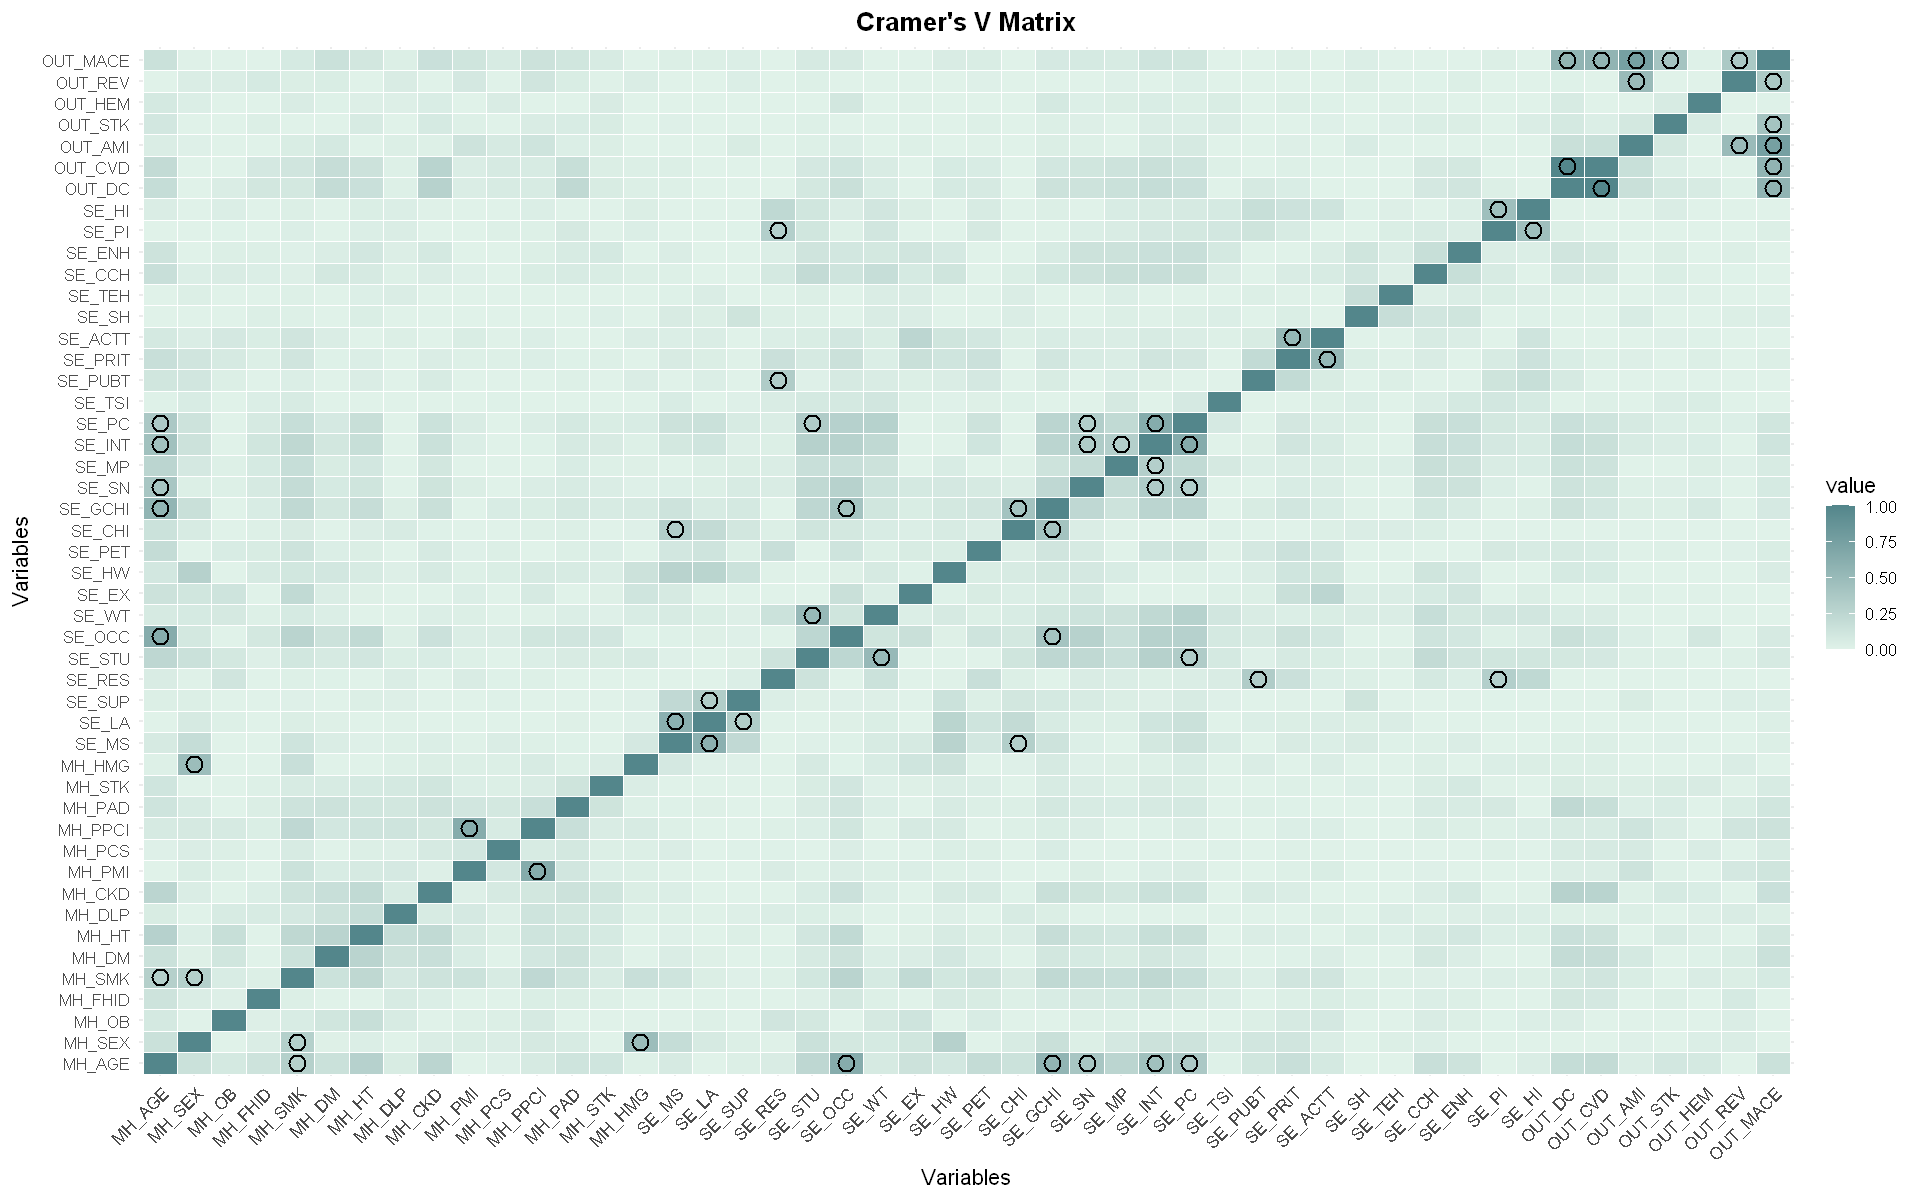

In [6]:
# Calculate the Cramer's V correlation matrix
correlation_matrix <- calculate_cramer_v(df)

# Plot the correlation matrix
suppressPackageStartupMessages(library(reshape2))
melted_corr <- melt(as.matrix(correlation_matrix))
# ggplot(melted_corr, aes(Var1, Var2, fill = value)) +
#     geom_tile(color = "white") +
#     scale_fill_gradient(low = "#e0f2e9", high = "#53868B", limits = c(0, 1)) +
#     labs(title = "Cramer's V Matrix", x = "Variables", y = "Variables") +
#     theme_minimal(base_size = 13) +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1),
#           plot.title = element_text(face = "bold", hjust = 0.5))

# Plot of the correlation matrix highlighting the strongest correlations
ggplot(melted_corr, aes(Var1, Var2, fill = value)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "#e0f2e9", high = "#53868B", limits = c(0, 1)) +
    geom_point(
        data = subset(melted_corr, value > 0.3 & Var1 != Var2),
        aes(Var1, Var2),
        shape = 21, color = "black", fill = NA, size = 4, stroke = 1
    ) +
    labs(title = "Cramer's V Matrix", x = "Variables", y = "Variables") +
    theme_minimal(base_size = 13) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(face = "bold", hjust = 0.5))

# Extract pairs with Cramer's V > 0.3 (excluding diagonal)
strong_corr_pairs <- subset(melted_corr, value > 0.3 & Var1 != Var2)

# Remove duplicate pairs (A,B) and (B,A)
strong_corr_pairs_unique <- strong_corr_pairs %>%
    rowwise() %>%
    mutate(pair = paste(sort(c(Var1, Var2)), collapse = " - ")) %>%
    ungroup() %>%
    distinct(pair, .keep_all = TRUE) %>%
    select(Var1, Var2, value)

# Print the table
knitr::kable(strong_corr_pairs_unique, col.names = c("Variable 1", "Variable 2", "Cramer's V"), digits = 3, align = "c")



| Variable 1 | Variable 2 | Cramer's V |
|:----------:|:----------:|:----------:|
|   SE_LA    |   SE_MS    |   0.599    |
|   SE_CHI   |   SE_MS    |   0.317    |
|   SE_SUP   |   SE_LA    |   0.336    |
|  SE_PUBT   |   SE_RES   |   0.338    |
|   SE_PI    |   SE_RES   |   0.314    |
|   SE_WT    |   SE_STU   |   0.513    |
|   SE_PC    |   SE_STU   |   0.337    |
|  SE_GCHI   |   SE_OCC   |   0.416    |
|  SE_GCHI   |   SE_CHI   |   0.422    |
|   SE_INT   |   SE_SN    |   0.343    |
|   SE_PC    |   SE_SN    |   0.325    |
|   SE_INT   |   SE_MP    |   0.310    |
|   SE_PC    |   SE_INT   |   0.641    |
|  SE_ACTT   |  SE_PRIT   |   0.527    |
|   SE_HI    |   SE_PI    |   0.457    |

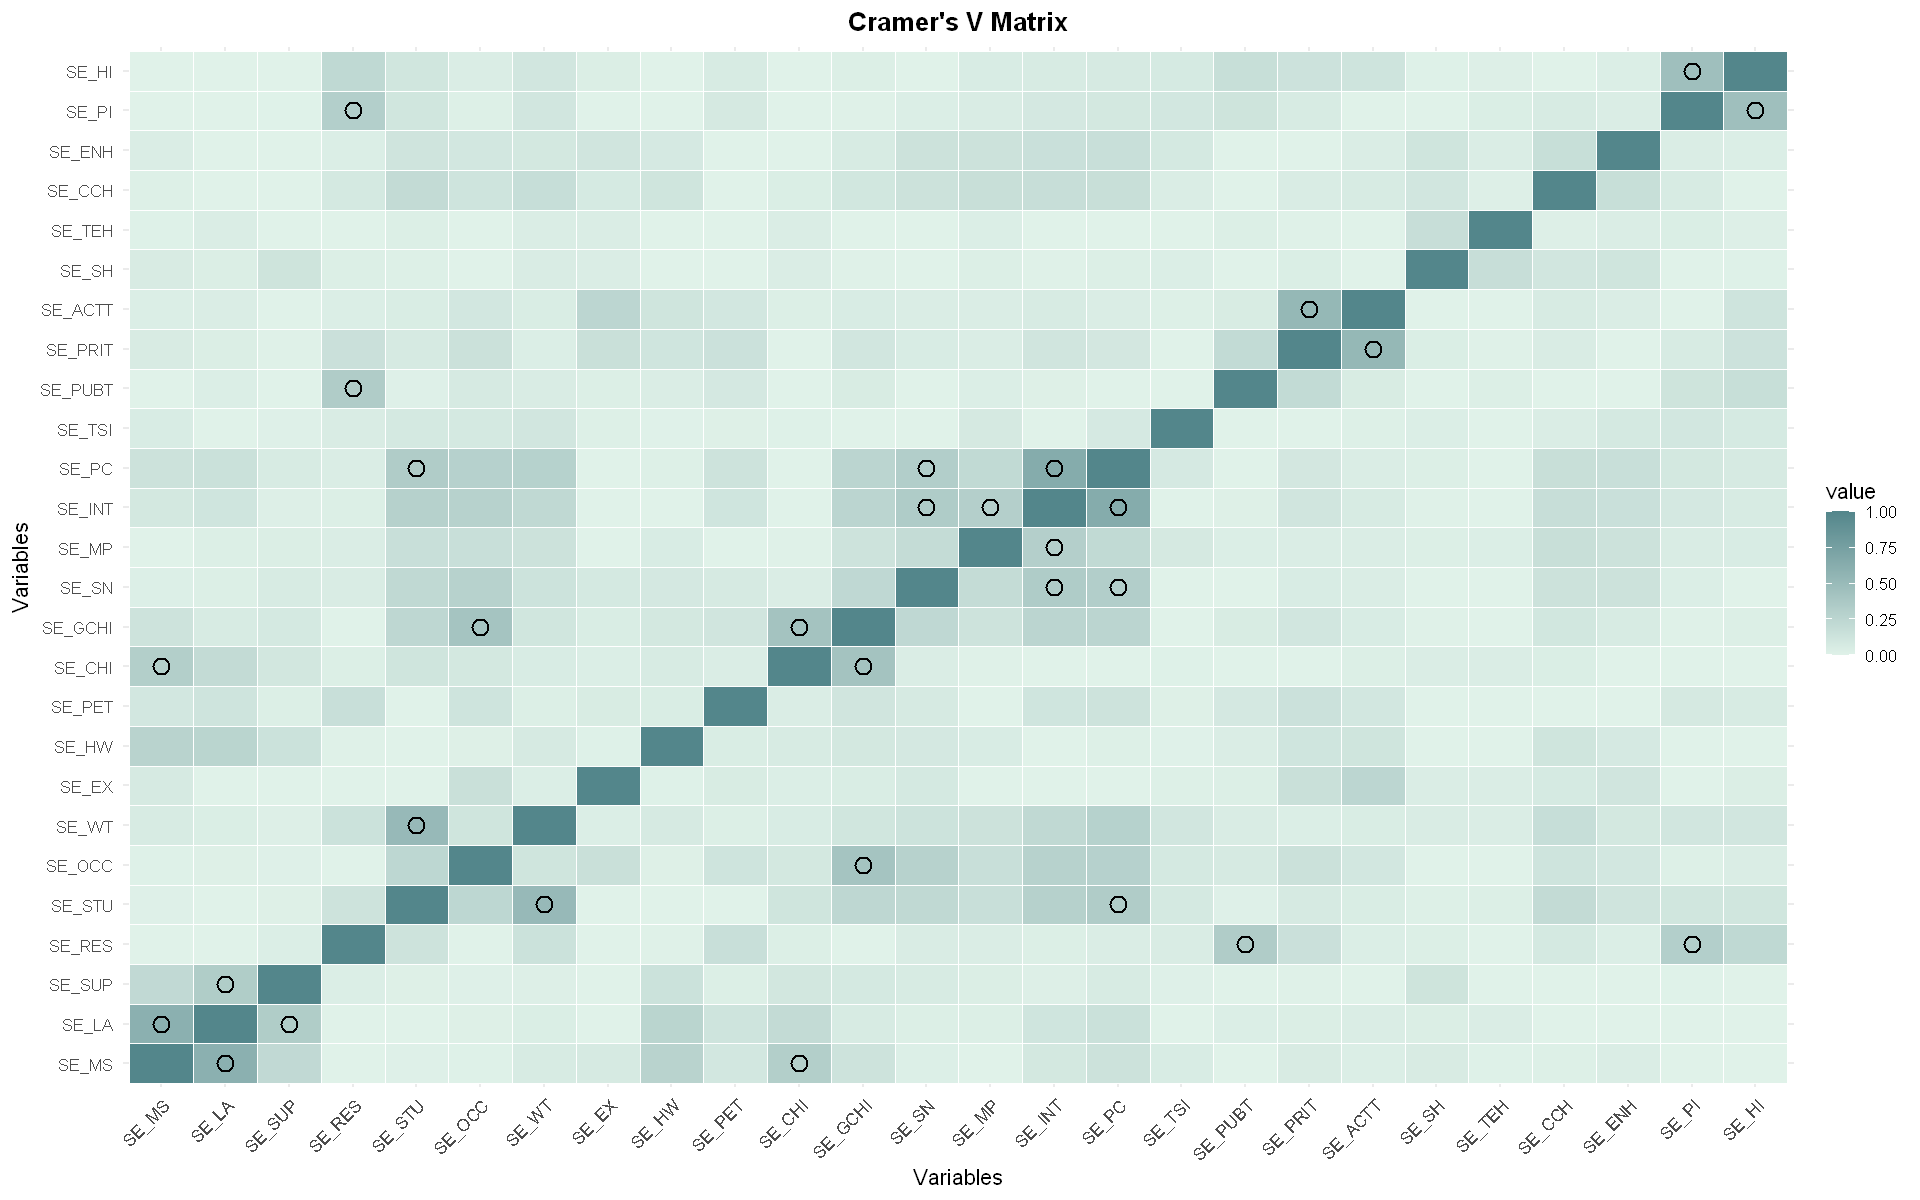

In [7]:
# Calculate the Cramer's V correlation matrix
correlation_matrix <- calculate_cramer_v(df %>% select(starts_with("SE_")))

# Plot the correlation matrix
suppressPackageStartupMessages(library(reshape2))
melted_corr <- melt(as.matrix(correlation_matrix))
# ggplot(melted_corr, aes(Var1, Var2, fill = value)) +
#     geom_tile(color = "white") +
#     scale_fill_gradient(low = "#e0f2e9", high = "#53868B", limits = c(0, 1)) +
#     labs(title = "Cramer's V Matrix", x = "Variables", y = "Variables") +
#     theme_minimal(base_size = 13) +
#     theme(axis.text.x = element_text(angle = 45, hjust = 1),
#           plot.title = element_text(face = "bold", hjust = 0.5))

# Plot of the correlation matrix highlighting the strongest correlations
ggplot(melted_corr, aes(Var1, Var2, fill = value)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "#e0f2e9", high = "#53868B", limits = c(0, 1)) +
    geom_point(
        data = subset(melted_corr, value > 0.3 & Var1 != Var2),
        aes(Var1, Var2),
        shape = 21, color = "black", fill = NA, size = 4, stroke = 1
    ) +
    labs(title = "Cramer's V Matrix", x = "Variables", y = "Variables") +
    theme_minimal(base_size = 13) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(face = "bold", hjust = 0.5))

# Extract pairs with Cramer's V > 0.3 (excluding diagonal)
strong_corr_pairs <- subset(melted_corr, value > 0.3 & Var1 != Var2)

# Remove duplicate pairs (A,B) and (B,A)
strong_corr_pairs_unique <- strong_corr_pairs %>%
    rowwise() %>%
    mutate(pair = paste(sort(c(Var1, Var2)), collapse = " - ")) %>%
    ungroup() %>%
    distinct(pair, .keep_all = TRUE) %>%
    select(Var1, Var2, value)

# Print the table
knitr::kable(strong_corr_pairs_unique, col.names = c("Variable 1", "Variable 2", "Cramer's V"), digits = 3, align = "c")



| Variable 1 | Variable 2 | Cramer's V |
|:----------:|:----------:|:----------:|
|   MH_SMK   |   MH_AGE   |   0.305    |
|   SE_OCC   |   MH_AGE   |   0.634    |
|   SE_INT   |   MH_AGE   |   0.445    |
|   MH_SMK   |   MH_SEX   |   0.305    |
|   MH_HMG   |   MH_SEX   |   0.482    |
|  MH_PPCI   |   MH_PMI   |   0.636    |
|  OUT_CVD   |   OUT_DC   |   1.000    |
|  OUT_MACE  |   OUT_DC   |   0.561    |
|  OUT_MACE  |  OUT_CVD   |   0.561    |
|  OUT_REV   |  OUT_AMI   |   0.495    |
|  OUT_MACE  |  OUT_AMI   |   0.749    |
|  OUT_MACE  |  OUT_STK   |   0.412    |
|  OUT_MACE  |  OUT_REV   |   0.373    |

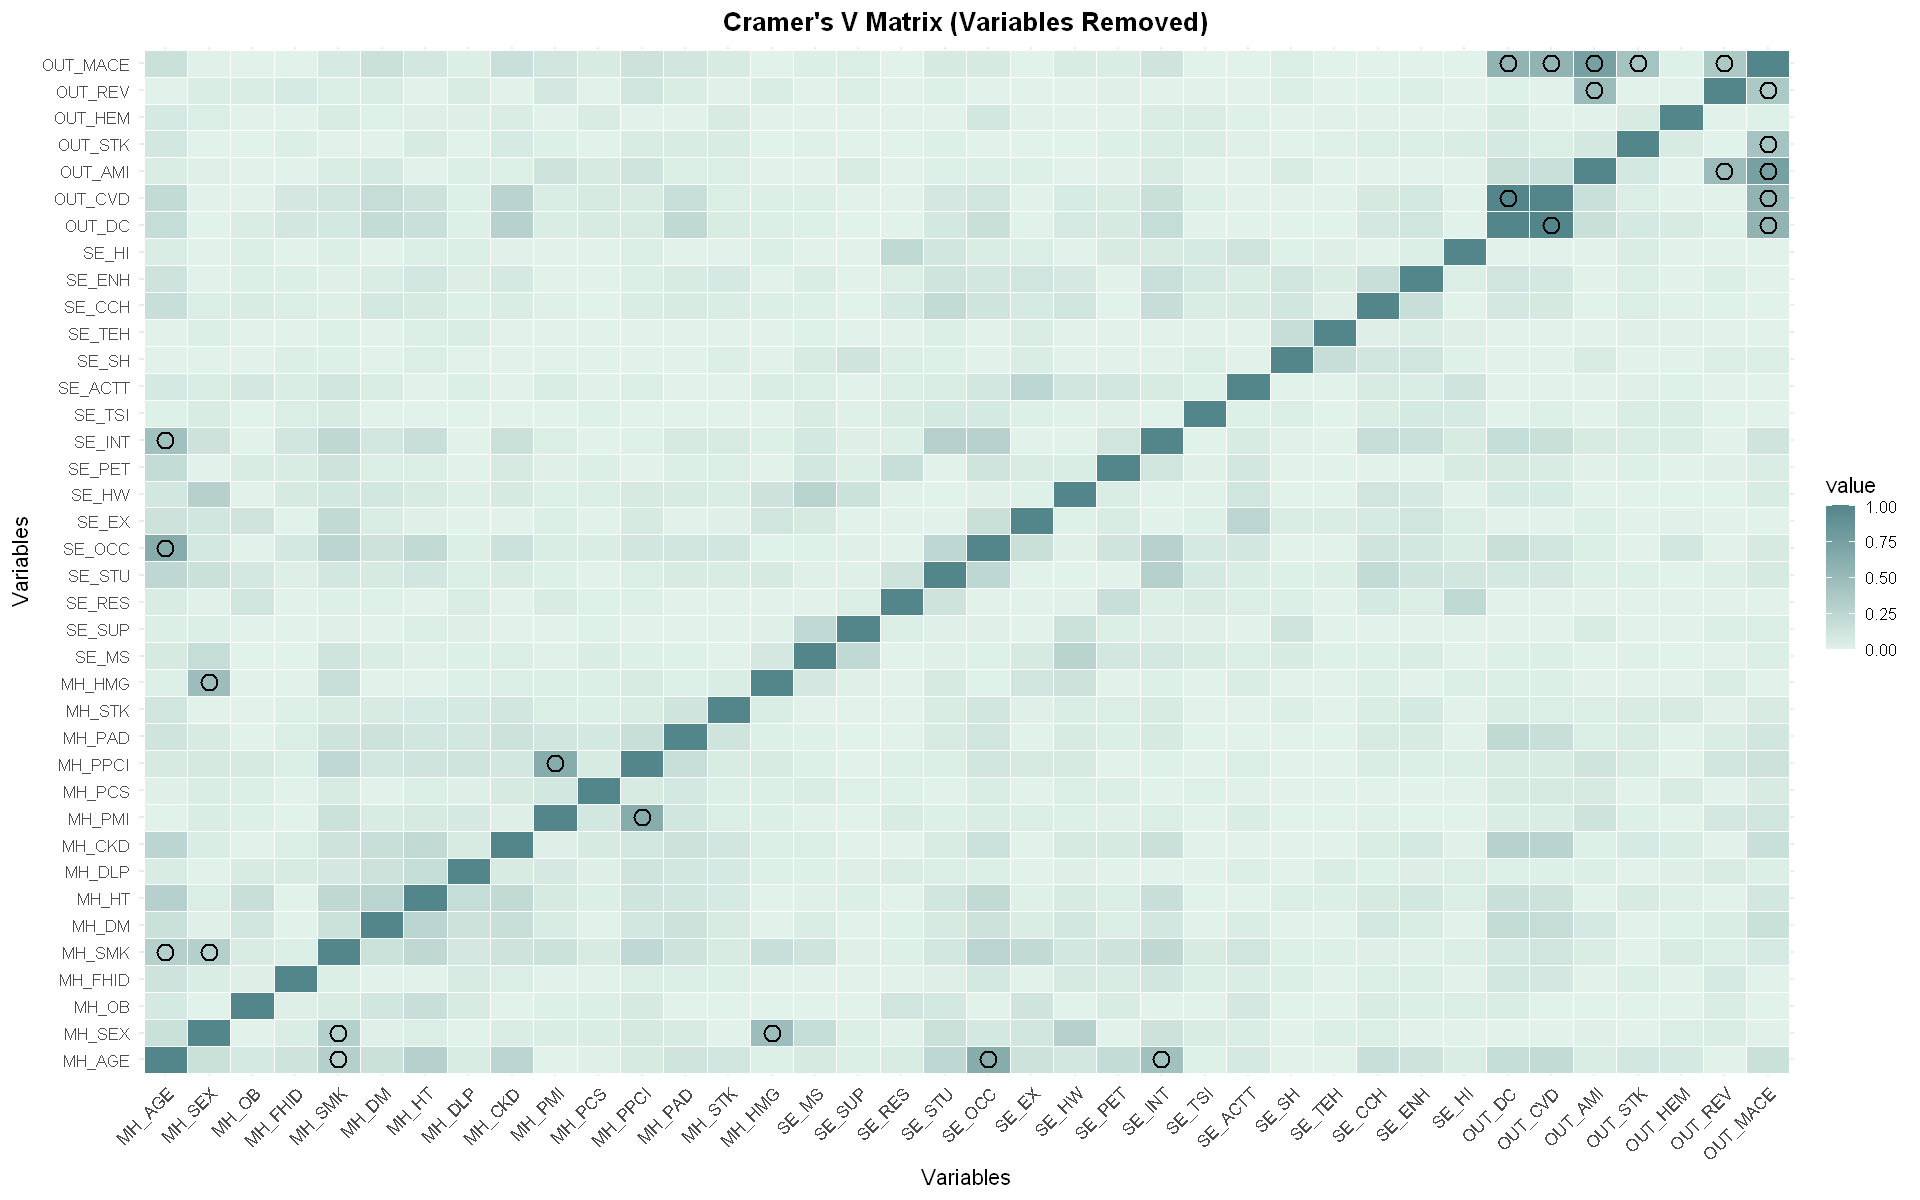

In [8]:
# Remove specified variables from df
vars_to_remove <- c(
    "SE_GCHI", "SE_CHI", "SE_LA", "SE_SN", "SE_PC", "SE_MP", "SE_WT", "SE_PUBT",
    "SE_PI", "SE_PRIT" #, "MH_PPCI"
)
df_reduced <- df %>% select(-all_of(vars_to_remove)) # %>% select(starts_with("SE_"))

# Calculate the Cramer's V correlation matrix for the reduced dataframe
correlation_matrix_reduced <- calculate_cramer_v(df_reduced)

# Plot the correlation matrix
melted_corr_reduced <- melt(as.matrix(correlation_matrix_reduced))
ggplot(melted_corr_reduced, aes(Var1, Var2, fill = value)) +
    geom_tile(color = "white") +
    scale_fill_gradient(low = "#e0f2e9", high = "#53868B", limits = c(0, 1)) +
    geom_point(
        data = subset(melted_corr_reduced, value > 0.3 & Var1 != Var2),
        aes(Var1, Var2),
        shape = 21, color = "black", fill = NA, size = 4, stroke = 1
    ) +
    labs(title = "Cramer's V Matrix (Variables Removed)", x = "Variables", y = "Variables") +
    theme_minimal(base_size = 13) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          plot.title = element_text(face = "bold", hjust = 0.5))

# Extract pairs with Cramer's V > 0.3 (excluding diagonal)
strong_corr_pairs_reduced <- subset(melted_corr_reduced, value > 0.3 & Var1 != Var2)

# Remove duplicate pairs (A,B) and (B,A)
strong_corr_pairs_unique_reduced <- strong_corr_pairs_reduced %>%
    rowwise() %>%
    mutate(pair = paste(sort(c(Var1, Var2)), collapse = " - ")) %>%
    ungroup() %>%
    distinct(pair, .keep_all = TRUE) %>%
    select(Var1, Var2, value)

# Print the table
knitr::kable(strong_corr_pairs_unique_reduced, col.names = c("Variable 1", "Variable 2", "Cramer's V"), digits = 3, align = "c")

In [9]:
str(df_reduced)
write.csv(df_reduced, "FINAL_DATASET.csv", row.names = FALSE)

'data.frame':	2109 obs. of  45 variables:
 $ ID          : int  1 2 3 4 5 6 10 12 13 17 ...
 $ MH_AGE      : Factor w/ 3 levels "(60,71]","(71,93]",..: 3 2 3 1 1 2 2 3 1 1 ...
 $ MH_SEX      : Factor w/ 2 levels "0","1": 2 2 2 1 2 2 1 2 2 1 ...
 $ MH_OB       : Factor w/ 2 levels "0","1": 2 2 1 1 2 1 1 1 1 2 ...
 $ MH_FHID     : Factor w/ 2 levels "0","1": 1 1 1 2 1 2 2 2 1 1 ...
 $ MH_SMK      : Factor w/ 3 levels "1","2","3": 1 3 1 3 2 1 3 1 2 1 ...
 $ MH_DM       : Factor w/ 2 levels "0","1": 1 1 1 1 2 1 1 1 1 2 ...
 $ MH_HT       : Factor w/ 2 levels "0","1": 2 2 1 1 2 2 2 1 1 2 ...
 $ MH_DLP      : Factor w/ 2 levels "0","1": 2 1 1 2 2 2 1 2 2 1 ...
 $ MH_CKD      : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 NA 1 ...
 $ MH_PMI      : Factor w/ 2 levels "0","1": 2 1 1 1 1 2 1 2 2 1 ...
 $ MH_PCS      : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ MH_PPCI     : Factor w/ 2 levels "0","1": 1 1 1 1 2 2 1 2 2 1 ...
 $ MH_PAD      : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1

### P-value for Chi-squared test

In [10]:
suppressPackageStartupMessages(library(lattice))

# Function to compute p-value of chi-squared test for each pair of variables
calculate_chi2_pvalues <- function(df) {
    variables <- setdiff(names(df), c('ID', 'OUT_Ddate', 'OUT_AMIdate', 'OUT_STKdate', 'OUT_HEMdate', 'OUT_REVdate', 'OUT_MACEdate'))
    n <- length(variables)
    pval_matrix <- matrix(NA, nrow = n, ncol = n) # Initialize matrix to store p-values
    for (i in seq_len(n)) { # Loop over rows (variables)
        for (j in seq_len(n)) { # Loop over columns (variables)
            if (i == j) {
                pval_matrix[i, j] <- NA # Set diagonal to NA (no test for same variable)
            } else {
                tbl <- table(df[[variables[i]]], df[[variables[j]]]) # Create contingency table
                test <- suppressWarnings(chisq.test(tbl, correct = FALSE)) # Perform chi-squared test
                pval_matrix[i, j] <- test$p.value # Store p-value in matrix
            }
        }
    }
    colnames(pval_matrix) <- variables
    rownames(pval_matrix) <- variables
    pval_matrix
}

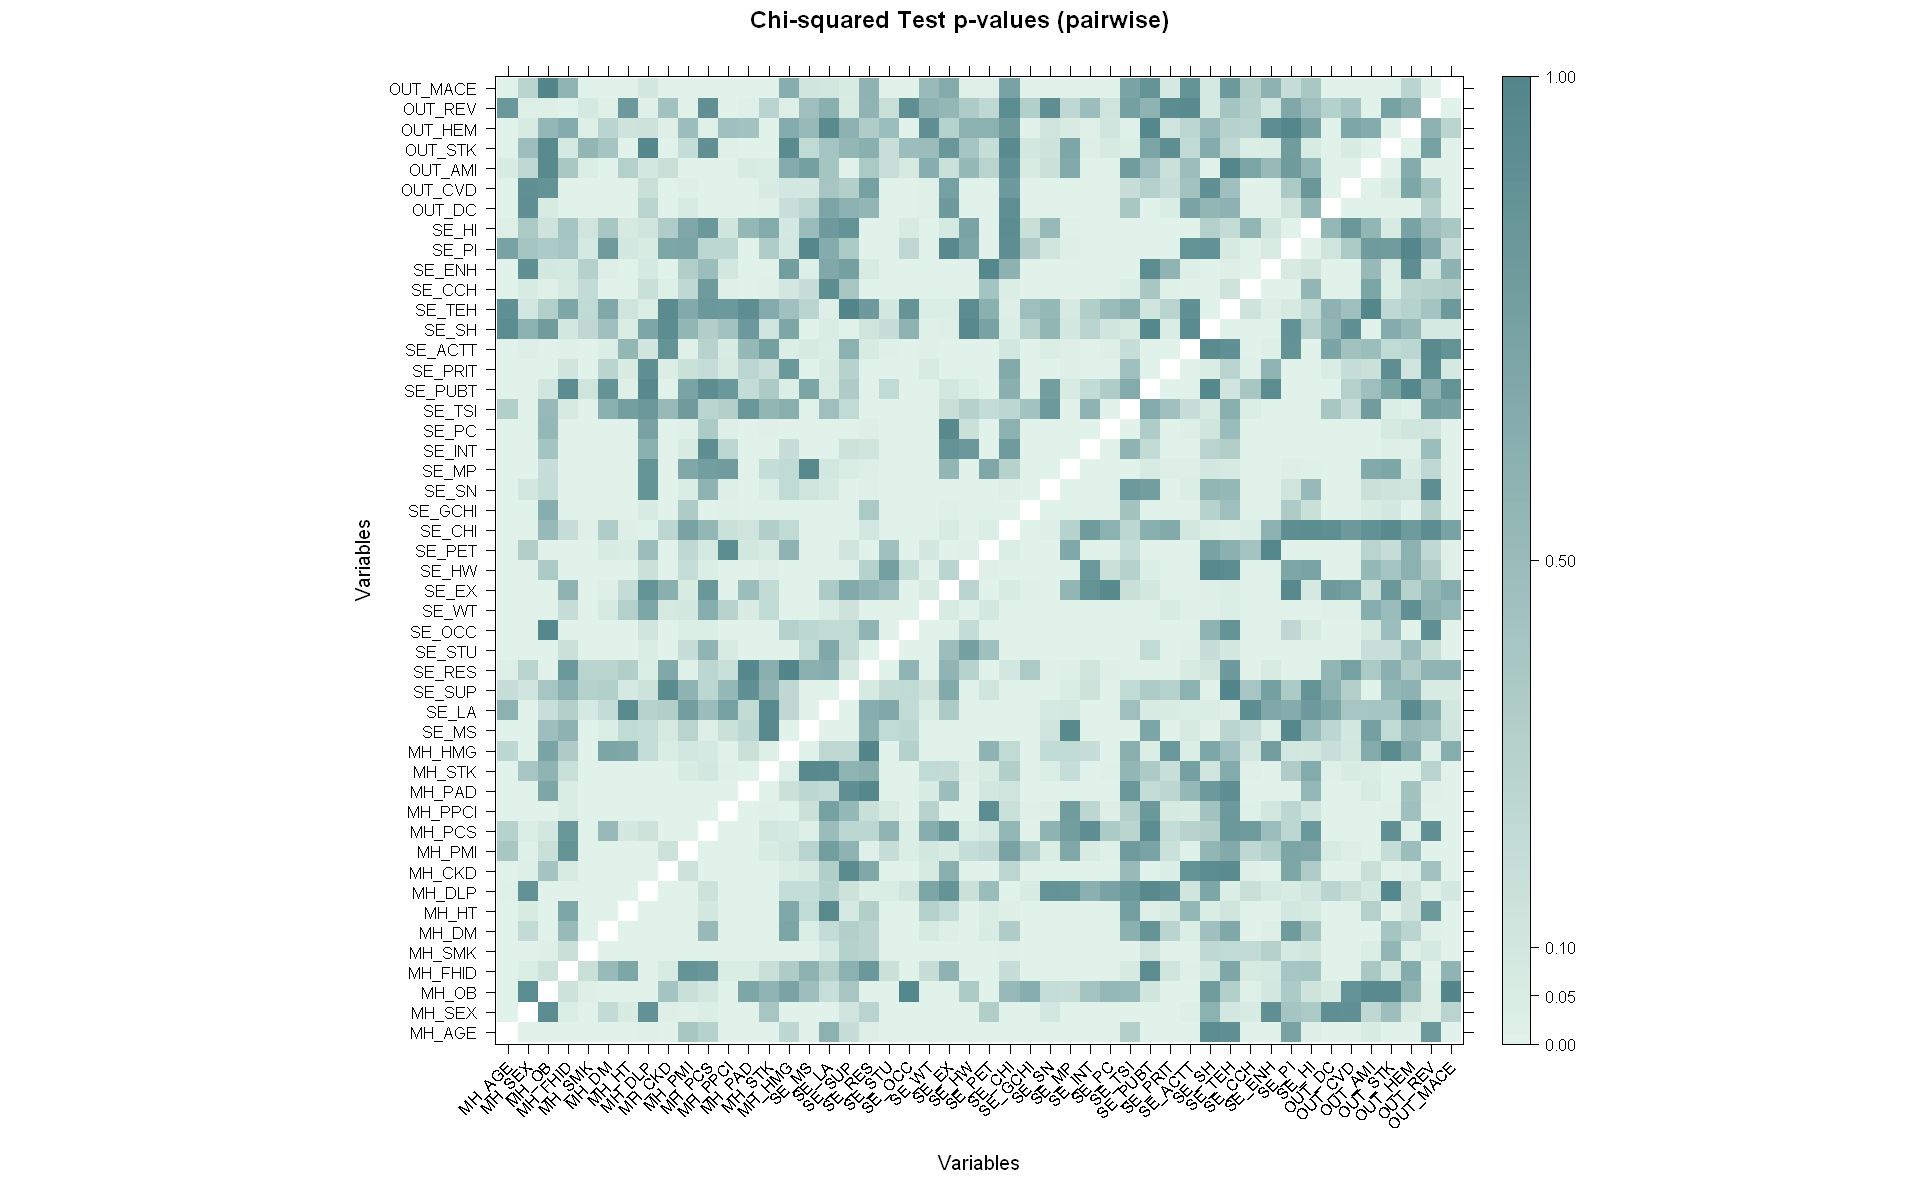

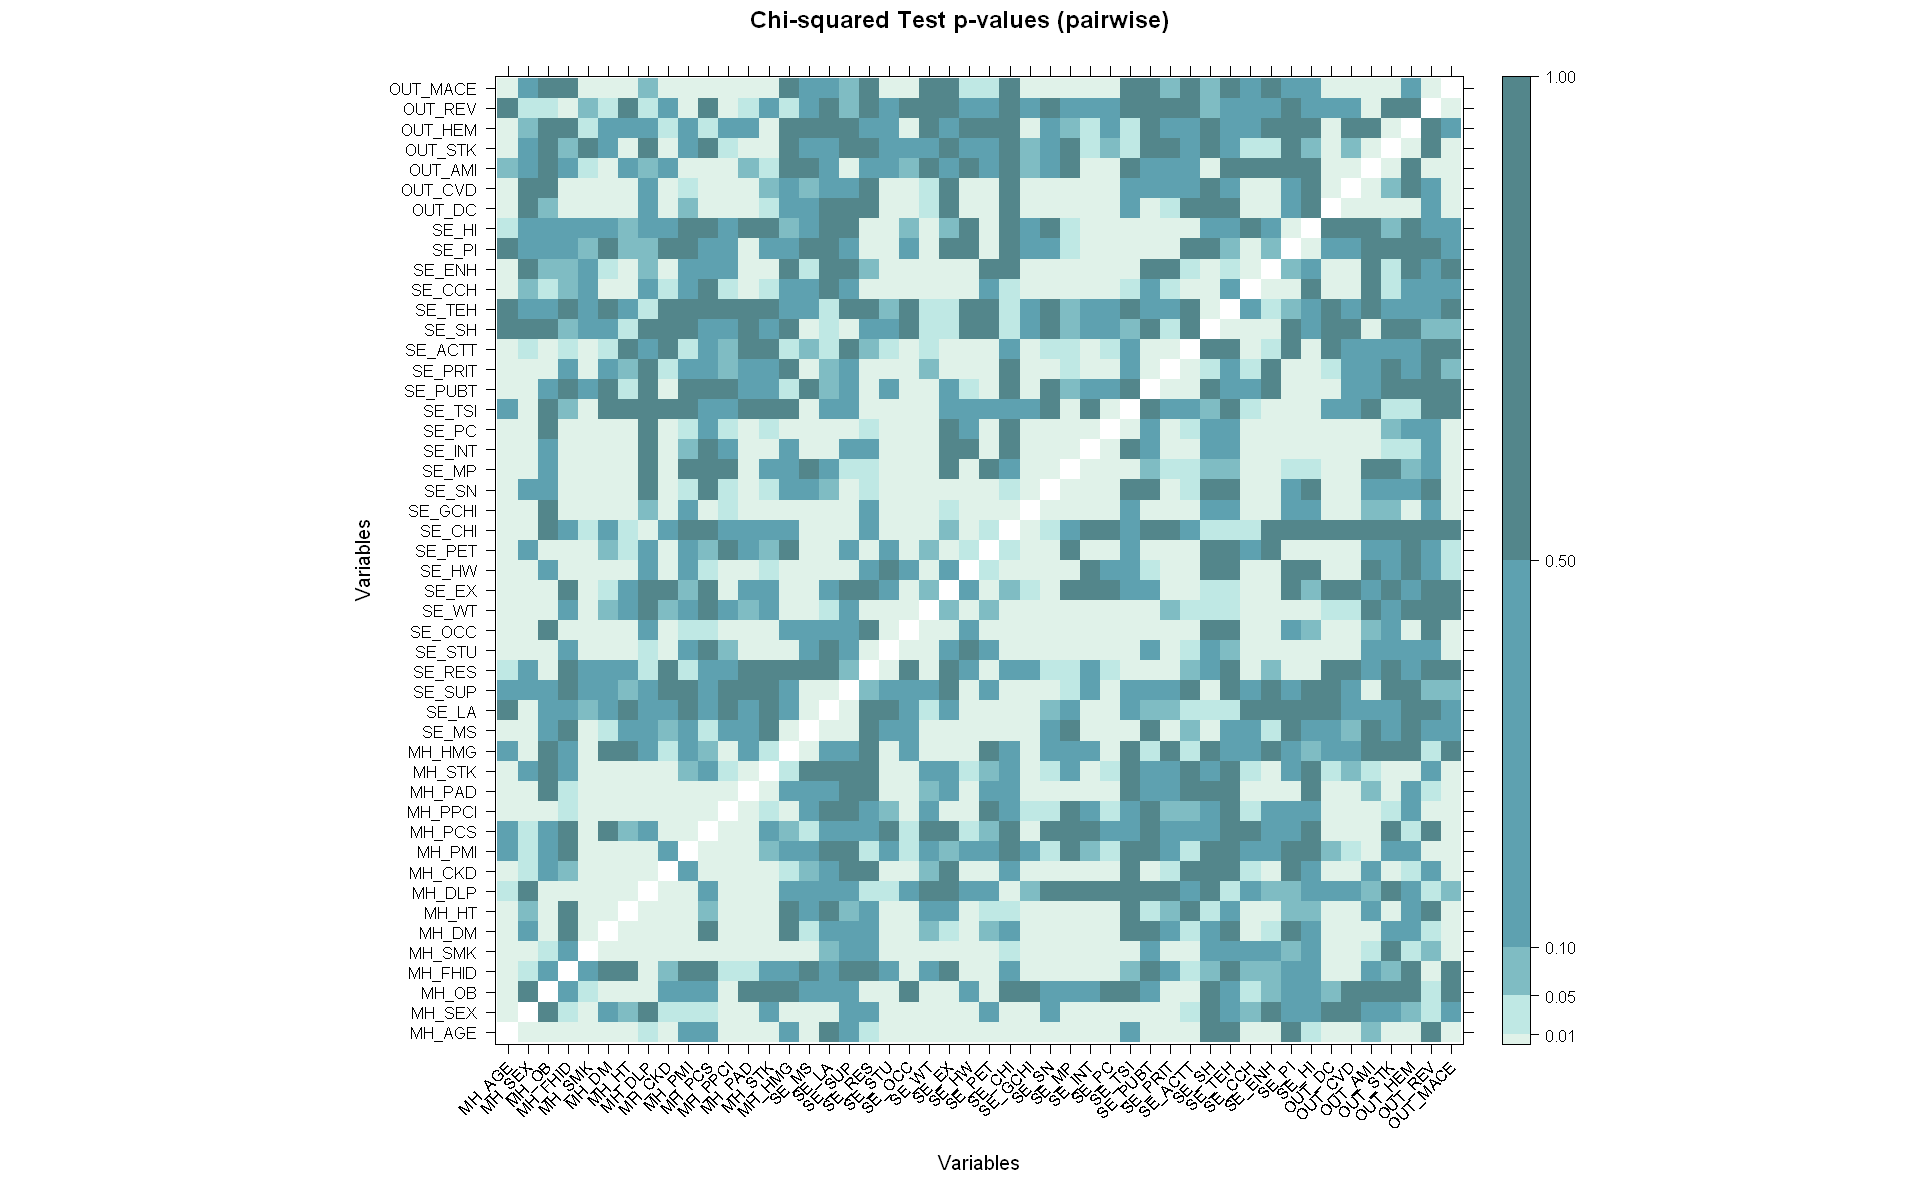

In [11]:
# Calculate p-value matrix
chi2_pval_matrix <- calculate_chi2_pvalues(df)

# Plot heatmap using lattice::levelplot
levelplot(
    chi2_pval_matrix,
    main = "Chi-squared Test p-values (pairwise)",
    xlab = "Variables",
    ylab = "Variables",
    col.regions = colorRampPalette(c("#e0f2e9","#53868B"))(100),
    at = seq(0, 1, length = 101),
    scales = list(x = list(rot = 45)),
    colorkey = list(space = "right", labels = list(at = c(0, 0.05, 0.1, 0.5, 1)))
)

# Define color breaks and corresponding colors for intervals
breaks <- c(0, 0.01, 0.05, 0.1, 0.5, 1)
interval_colors <- c("#e0f2e9", "#BFE8E4", "#7FBCC3", "#5EA1B0", "#53868B")

# Plot heatmap using lattice::levelplot with custom colors for intervals
levelplot(
    chi2_pval_matrix,
    main = "Chi-squared Test p-values (pairwise)",
    xlab = "Variables",
    ylab = "Variables",
    at = breaks,
    col.regions = interval_colors,
    scales = list(x = list(rot = 45)),
    colorkey = list(
        space = "right",
        at = breaks,
        labels = list(
            at = c(0.01, 0.05, 0.1, 0.5, 1)
        )
    )
)

# # Extract pairs with p-value < 0.05 (excluding diagonal)
# pval_df <- as.data.frame(as.table(chi2_pval_matrix))
# colnames(pval_df) <- c("Var1", "Var2", "p_value")
# strong_pval_pairs <- subset(pval_df, p_value < 0.05 & Var1 != Var2)

# # Remove duplicate pairs (A,B) and (B,A)
# strong_pval_pairs_unique <- strong_pval_pairs %>%
#     rowwise() %>%
#     mutate(pair = paste(sort(c(Var1, Var2)), collapse = " - ")) %>%
#     ungroup() %>%
#     distinct(pair, .keep_all = TRUE) %>%
#     select(Var1, Var2, p_value)

# # Print the table
# knitr::kable(strong_pval_pairs_unique, col.names = c("Variable 1", "Variable 2", "p-value"), digits = 6, align = "c")


If *p-value* is lower than 0.05 then the null hypothesis, the variables are independent, is rejected. Thus if *p-value < 0.05* variables might be asociated.

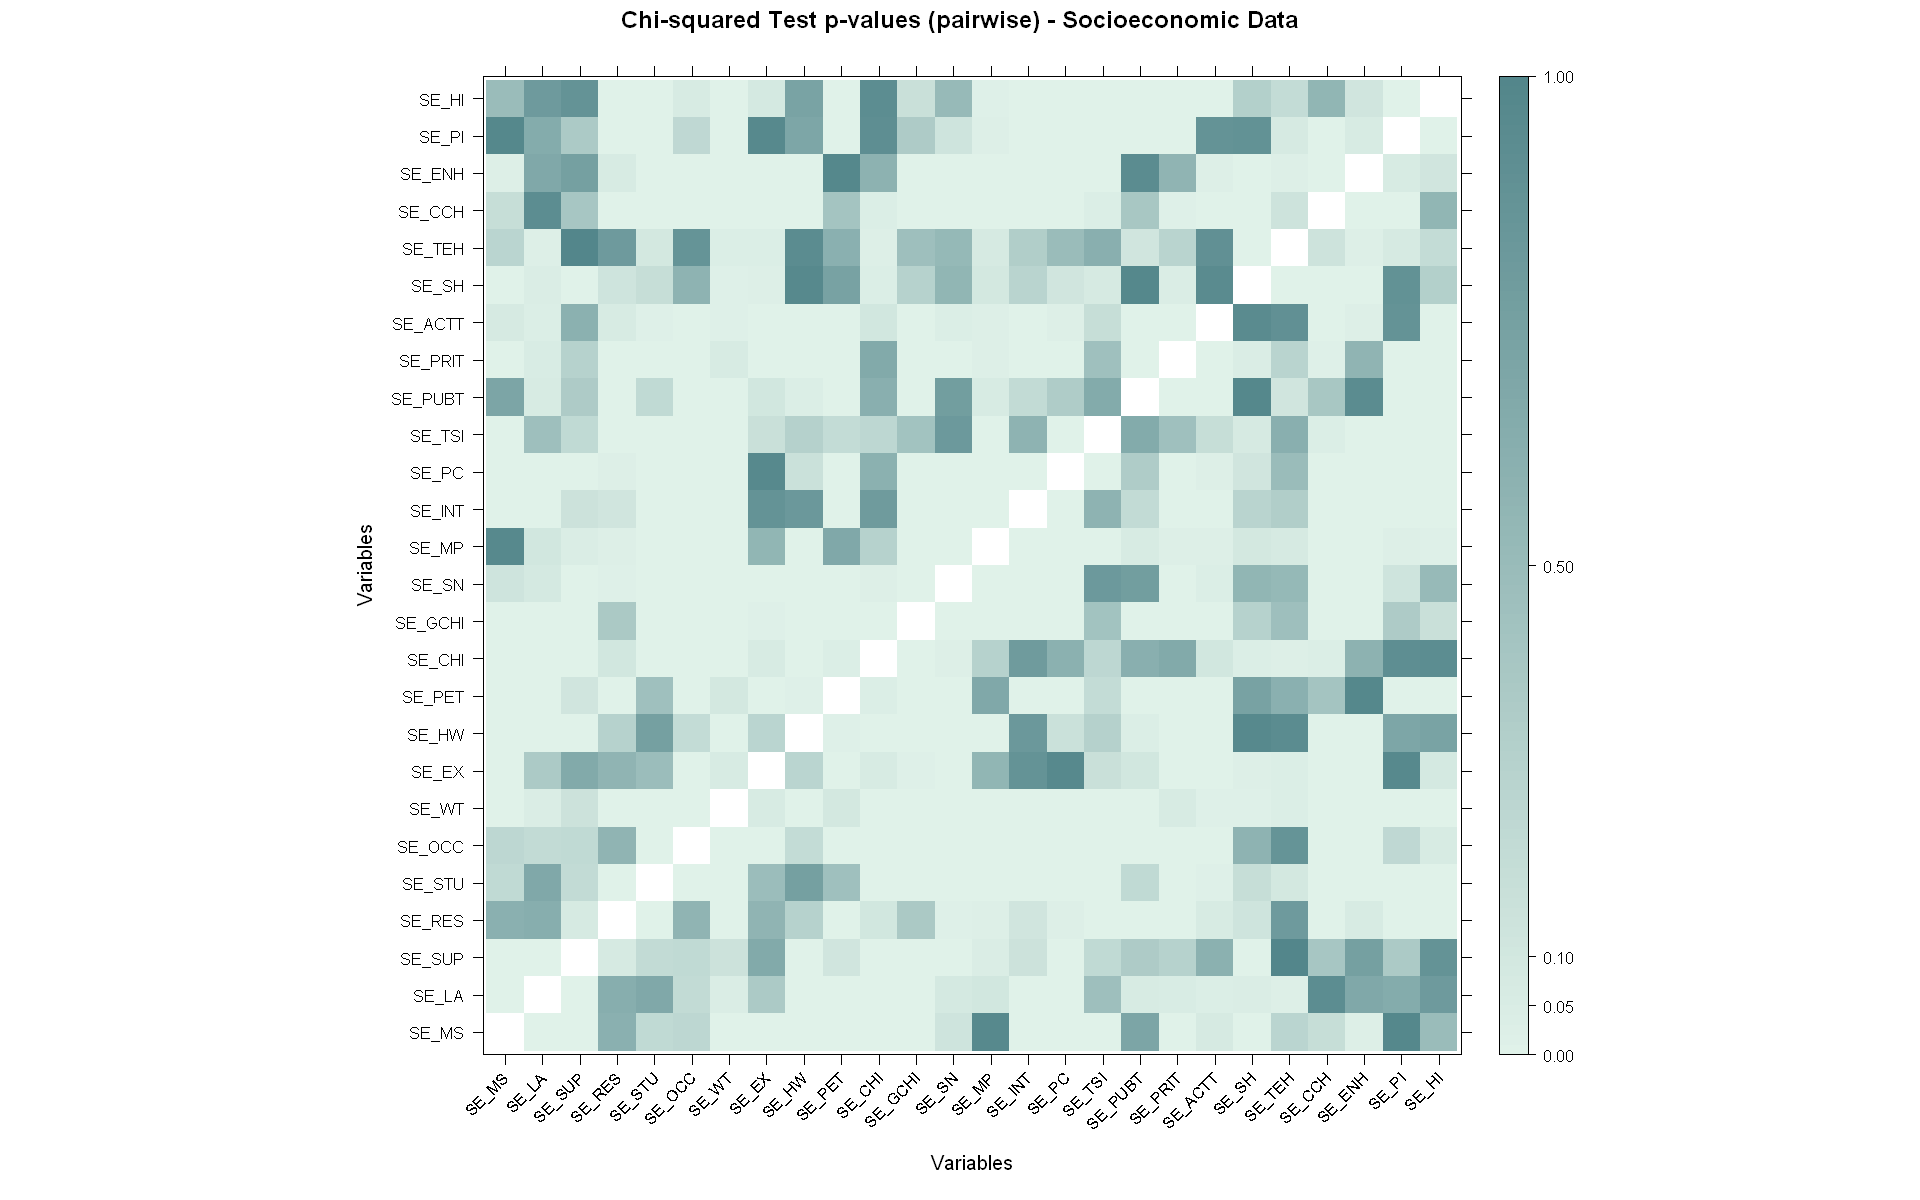

The following pairs of socioeconomic variables have a p-value < 0.05, thus rejecenting the hypothesis that they are independent:




| Variable 1 | Variable 2 | p-value  |
|:----------:|:----------:|:--------:|
|   SE_LA    |   SE_MS    | 0.000000 |
|   SE_SUP   |   SE_MS    | 0.000000 |
|   SE_WT    |   SE_MS    | 0.002035 |
|   SE_EX    |   SE_MS    | 0.001049 |
|   SE_HW    |   SE_MS    | 0.000000 |
|   SE_PET   |   SE_MS    | 0.000005 |
|   SE_CHI   |   SE_MS    | 0.000000 |
|  SE_GCHI   |   SE_MS    | 0.000000 |
|   SE_INT   |   SE_MS    | 0.000016 |
|   SE_PC    |   SE_MS    | 0.000000 |
|   SE_TSI   |   SE_MS    | 0.008870 |
|  SE_PRIT   |   SE_MS    | 0.004180 |
|   SE_SH    |   SE_MS    | 0.003882 |
|   SE_ENH   |   SE_MS    | 0.029052 |
|   SE_SUP   |   SE_LA    | 0.000000 |
|   SE_WT    |   SE_LA    | 0.040438 |
|   SE_HW    |   SE_LA    | 0.000000 |
|   SE_PET   |   SE_LA    | 0.000000 |
|   SE_CHI   |   SE_LA    | 0.000000 |
|  SE_GCHI   |   SE_LA    | 0.001552 |
|   SE_INT   |   SE_LA    | 0.000000 |
|   SE_PC    |   SE_LA    | 0.000000 |
|  SE_ACTT   |   SE_LA    | 0.036236 |
|   SE_SH    |   SE_LA 

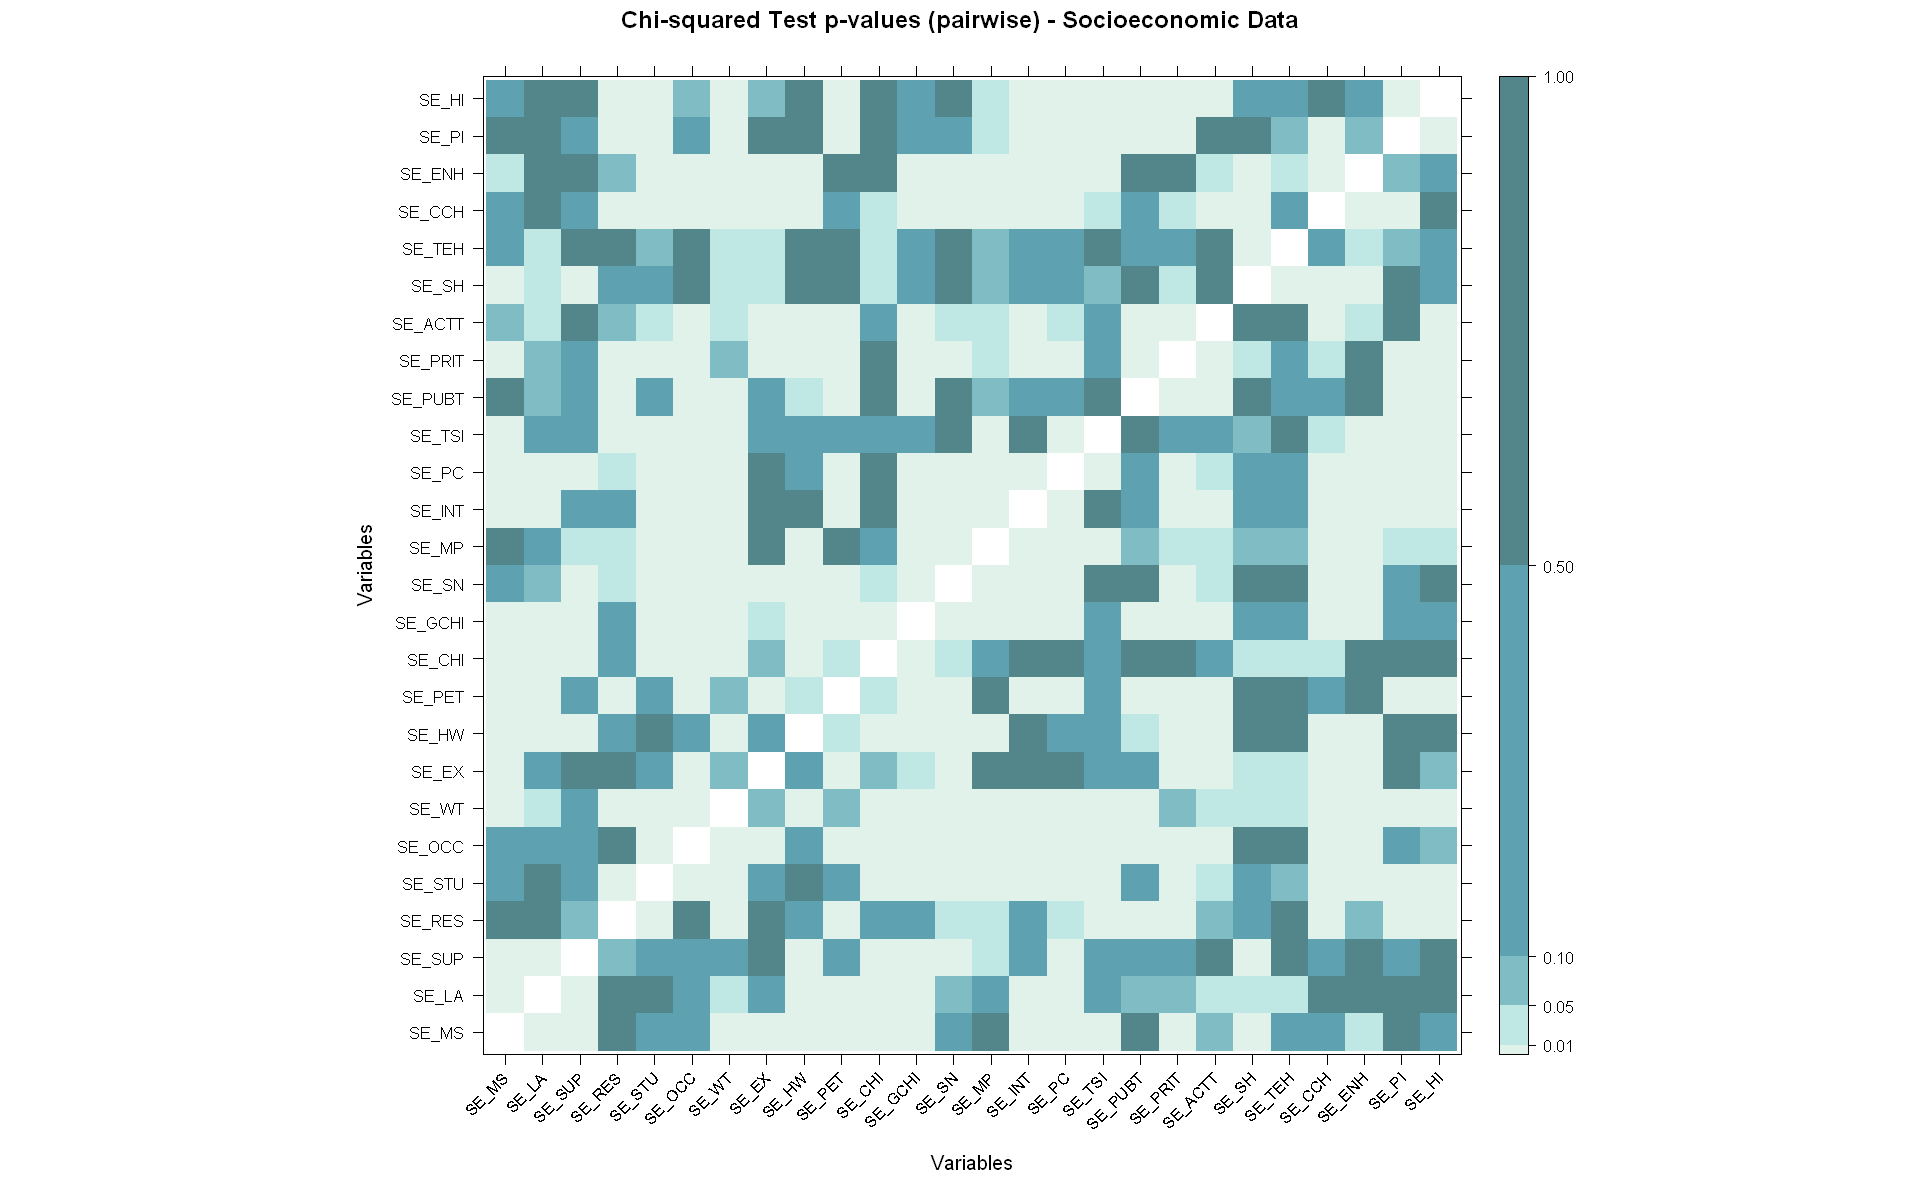

In [12]:
# Read the socioeconomic dataset
SOCIOECONOMIC_DATASET <- read.csv('SOCIOECONOMIC_DATASET.csv')

# Calculate p-value matrix for socioeconomic variables
chi2_pval_matrix_se <- calculate_chi2_pvalues(SOCIOECONOMIC_DATASET)

# Plot heatmap using lattice::levelplot
levelplot(
    chi2_pval_matrix_se,
    main = "Chi-squared Test p-values (pairwise) - Socioeconomic Data",
    xlab = "Variables",
    ylab = "Variables",
    col.regions = colorRampPalette(c("#e0f2e9","#53868B"))(100),
    at = seq(0, 1, length = 101),
    scales = list(x = list(rot = 45)),
    colorkey = list(space = "right", labels = list(at = c(0, 0.05, 0.1, 0.5, 1)))
)

# Define color breaks and corresponding colors for intervals
breaks <- c(0, 0.01, 0.05, 0.1, 0.5, 1)
interval_colors <- c("#e0f2e9", "#BFE8E4", "#7FBCC3", "#5EA1B0", "#53868B")

# Plot heatmap using lattice::levelplot with custom colors for intervals
levelplot(
    chi2_pval_matrix_se,
    main = "Chi-squared Test p-values (pairwise) - Socioeconomic Data",
    xlab = "Variables",
    ylab = "Variables",
    at = breaks,
    col.regions = interval_colors,
    scales = list(x = list(rot = 45)),
    colorkey = list(
        space = "right",
        at = breaks,
        labels = list(
            at = c(0.01, 0.05, 0.1, 0.5, 1)
        )
    )
)

# Extract pairs with p-value < 0.05 (excluding diagonal)
pval_df <- as.data.frame(as.table(chi2_pval_matrix_se))
colnames(pval_df) <- c("Var1", "Var2", "p_value")
strong_pval_pairs <- subset(pval_df, p_value < 0.05 & Var1 != Var2)

# Remove duplicate pairs (A,B) and (B,A)
strong_pval_pairs_unique <- strong_pval_pairs %>%
    rowwise() %>%
    mutate(pair = paste(sort(c(Var1, Var2)), collapse = " - ")) %>%
    ungroup() %>%
    distinct(pair, .keep_all = TRUE) %>%
    select(Var1, Var2, p_value)

# Print the table
cat("The following pairs of socioeconomic variables have a p-value < 0.05, thus rejecenting the hypothesis that they are independent:\n")
knitr::kable(strong_pval_pairs_unique, col.names = c("Variable 1", "Variable 2", "p-value"), digits = 6, align = "c")